In [1]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [2]:
dataset_filename = "../../preprocessing/data/processed_merge.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
0,0,21636,Sandwich,richardson174.cha,okay . [+ exc] 564200_564650,okay.,0
1,1,785,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
2,2,14488,Window,capilouto44a.cha,where he is beside him . 1304770_1306020,where he is beside him.,0
3,3,6865,Umbrella,62-1.cha,it's pouring . 794962_795602,it's pouring.,0
4,4,33578,Umbrella,wright34a.cha,&-uh every morning mommy gets Billy ready for ...,every morning mommy gets billy ready for school.,0


In [4]:
# no null values 
df.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0           0
scenario             0
source_file          0
original_text        0
preprocessed_text    0
label                0
dtype: int64

In [6]:
sentences = df["preprocessed_text"]

<Axes: xlabel='label', ylabel='count'>

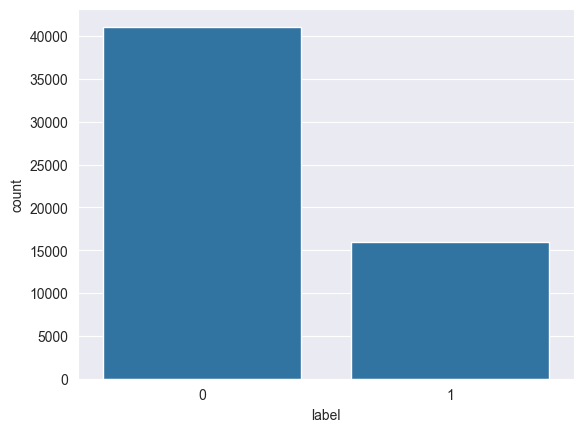

In [7]:
# A bit unbalanced
sns.countplot(x="label",data=df)

In [8]:
input_df = df

In [9]:
input_df

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
0,0,21636,Sandwich,richardson174.cha,okay . [+ exc] 564200_564650,okay.,0
1,1,785,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
2,2,14488,Window,capilouto44a.cha,where he is beside him . 1304770_1306020,where he is beside him.,0
3,3,6865,Umbrella,62-1.cha,it's pouring . 794962_795602,it's pouring.,0
4,4,33578,Umbrella,wright34a.cha,&-uh every morning mommy gets Billy ready for ...,every morning mommy gets billy ready for school.,0
...,...,...,...,...,...,...,...
57046,57046,28585,Important_Event,UNH1034.cha,something that was so foreign to me to just as...,something that was so foreign to me to just as...,0
57047,57047,27856,Cinderella,UMD24.cha,the prince continues to wave her away . 13682...,the prince continues to wave her away.,0
57048,57048,28812,Cinderella,UNH1034.cha,and she was off to the ball . 1993565_1994535,and she was off to the ball.,0
57049,57049,342,Umbrella,adler11a.cha,yeah &=points:frame_5 . [+ exc] 694075_694992,yeah.,1


# Encoding # 1

In [11]:
import multiprocessing
from gensim.models import Word2Vec

In [10]:
cores = multiprocessing.cpu_count()
cores

16

In [11]:
words_in_sentences=[]
for i in input_df["preprocessed_text"]:
    words_in_sentences.append(re.findall(r"[\w']+|[.,!?;]", i.lower()))
words_in_sentences[20]

['the',
 'only',
 'thing',
 'worthwhile',
 'is',
 'colin',
 'firth',
 ',',
 'and',
 'he',
 'seems',
 'slightly',
 'embarrassed',
 'throughout',
 '.']

In [12]:
input_df.iloc[20]

modified    the only thing worthwhile is colin firth, and ...
label                                                       0
Name: 20, dtype: object

In [13]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-10)

In [14]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [15]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(9559437, 24092910)

In [16]:
w2v_model.save("word2vec_knn.model")

In [13]:
w2v_model = Word2Vec.load("word2vec_knn.model")

In [14]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

9815


In [15]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [17]:
transformed_text, labels1= avg_w2vec(input_df["preprocessed_text"], input_df["label"])

# Model fitting

In [18]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# odd k for preventing ties
grid_params = { 'n_neighbors' : [3, 5, 7, 9, 11],
               'metric' : ['manhattan', 'minkowski', 'cosine']}

In [23]:
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, grid_params, n_jobs=10, verbose=1, return_train_score=True)
clf.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=10,
             param_grid={'metric': ['manhattan', 'minkowski', 'cosine'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             return_train_score=True, verbose=1)

In [24]:
result_df = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                       pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["mean_test_acc"]),
                       pd.DataFrame(clf.cv_results_["mean_train_score"], columns=["mean_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_train_score"], columns=["std_train_acc"]),
                       pd.DataFrame(clf.cv_results_["std_test_score"], columns=["std_test_acc"])], axis=1)

In [25]:
result_df.to_csv("knn-reverse-results.csv")

In [26]:
clf.best_params_

{'metric': 'cosine', 'n_neighbors': 3}

In [27]:
clf.cv_results_ 

{'mean_fit_time': array([0.08851566, 0.08621554, 0.06817994, 0.05857296, 0.05531383,
        0.05849199, 0.0640089 , 0.05857558, 0.07684102, 0.07536631,
        0.08136506, 0.0740088 , 0.06660047, 0.07870049, 0.06713519]),
 'std_fit_time': array([0.00390238, 0.00412843, 0.00616389, 0.00146328, 0.00158894,
        0.00281249, 0.00721579, 0.00186006, 0.00303848, 0.00620319,
        0.01154694, 0.01227799, 0.0089388 , 0.00451216, 0.00905086]),
 'mean_score_time': array([50.8129426 , 50.83725433, 51.83397999, 51.82533703, 54.02284656,
         4.34807878,  4.337042  ,  4.2929996 ,  5.6978097 ,  5.13740702,
         9.28736105,  7.19029431,  8.08544278, 10.0487854 ,  7.30386572]),
 'std_score_time': array([0.01632229, 0.04842712, 0.05655476, 0.02750471, 0.12852207,
        0.14565522, 0.06510233, 0.05596443, 0.25894926, 0.25698473,
        0.59648352, 0.13878372, 0.71995801, 0.30725715, 0.51074506]),
 'param_metric': masked_array(data=['manhattan', 'manhattan', 'manhattan', 'manhattan',
   

In [28]:
knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'], metric=clf.best_params_['metric'])
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [29]:
knnPickle = open('knn_pickle', 'wb')
pickle.dump(knn, knnPickle)
knnPickle.close()

# Training + testing plots

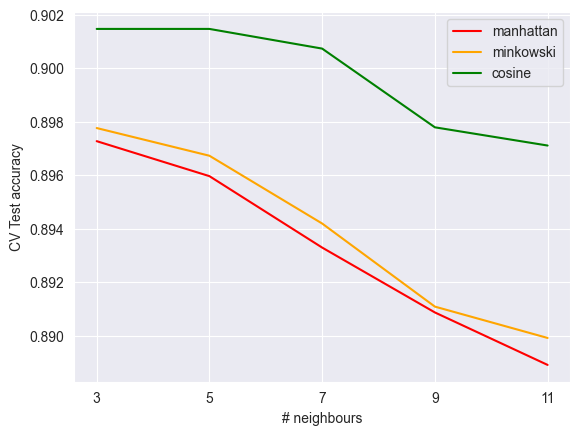

In [30]:
import matplotlib.pyplot as plt

result_df = pd.read_csv("knn-reverse-results.csv", encoding="utf-8")
cols = ['red', 'orange', 'green']
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_test_acc, color=col, label=metric)

plt.xlabel("# neighbours")
plt.ylabel("CV Test accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

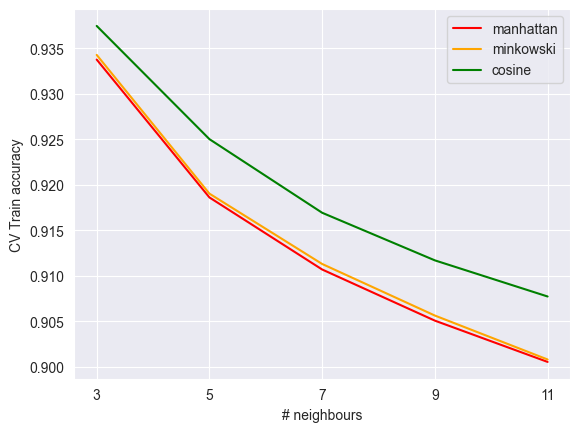

In [31]:
for metric, col in zip(grid_params['metric'], cols):
    plt.plot(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc, color=col, label=metric)
    # plt.fill_between(result_df[result_df.metric == metric].n_neighbors, result_df[result_df.metric == metric].mean_train_acc - result_df[result_df.metric == metric].std_train_acc,result_df[result_df.metric == metric].mean_train_acc + result_df[result_df.metric == metric].std_train_acc)

plt.xlabel("# neighbours")
plt.ylabel("CV Train accuracy")
plt.xticks(grid_params['n_neighbors'])
plt.legend()
plt.show()

# Evaluation

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [21]:
loaded_model = pickle.load(open('../models/knn_pickle', 'rb'))

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
loaded_model

KNeighborsClassifier(metric='cosine', n_neighbors=7)

In [23]:
result = loaded_model.predict(x_test)

In [24]:
len(x_test)

10304

In [25]:
len(y_test)

10304

In [26]:
print(accuracy_score(y_test, result))

0.8726708074534162


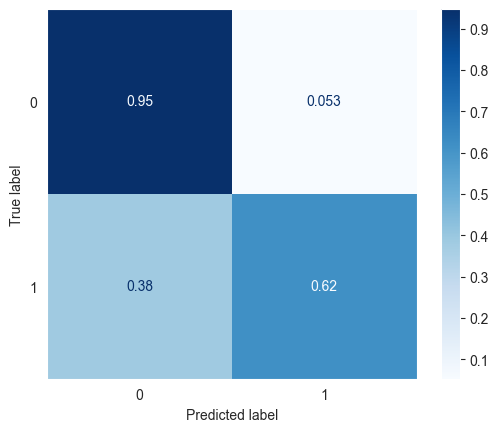

In [27]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [28]:
print(tn, fn, tp, fp)

0.9469469469469469 0.38408304498269896 0.615916955017301 0.05305305305305305


In [29]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9206944221519217
0.615916955017301
0.7380803154508665
